# Using GCM to solve Pearl's example

In [8]:
from dowhy import gcm
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

### Creating the GCM

#### Setting the DAG

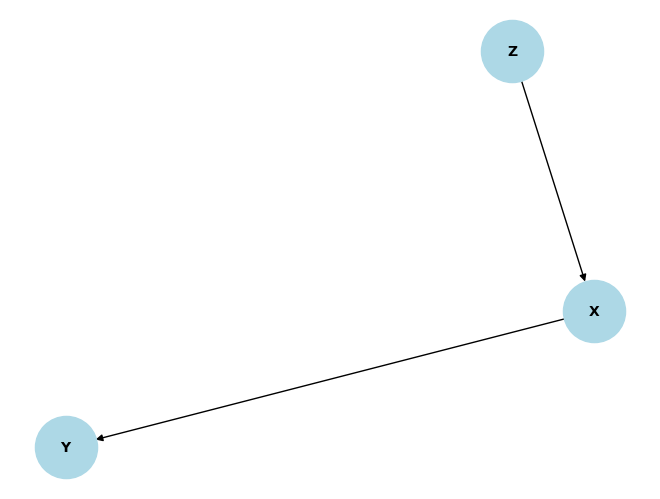

In [9]:
causal_graph = nx.DiGraph([
    ('Z', 'X'),
    ('X', 'Y')
])

causal_model = gcm.StructuralCausalModel(causal_graph)

nx.draw(causal_graph, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')
plt.show()

#### Setting the causal mechanisms

In [10]:
# Since Z is an exogenous variable, we can set its distribution to be empirical
# For X and Y, we can set their causal mechanisms to be classifiers, which can be trained on data
causal_model.set_causal_mechanism('Z', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('X', gcm.ClassifierFCM())
causal_model.set_causal_mechanism('Y', gcm.ClassifierFCM())

#### Retrieving data

In [11]:
data = pd.read_csv("../data/balke_pearl.csv")
data = data.astype(str)
print(data.head())

   Z  X  Y
0  0  0  0
1  0  0  0
2  0  0  0
3  0  0  0
4  0  0  0


#### Fitting the model and generating new data

In [12]:
gcm.fit(causal_model, data)
generated_data = gcm.draw_samples(causal_model, num_samples=1000)
print(generated_data.head())

Fitting causal mechanism of node Y: 100%|██████████| 3/3 [00:00<00:00, 25.75it/s]

   Z  X  Y
0  0  0  0
1  0  0  0
2  0  0  0
3  0  1  0
4  0  1  0


### Calculating the ACE

In [13]:
gcm.average_causal_effect(causal_model,
                         'Y',
                         interventions_alternative={'X': lambda x: '1'},
                         interventions_reference={'X': lambda x: '0'},
                         num_samples_to_draw=1000)

### Estimating confidence intervals (Confidence level = 0.95)

In [14]:
gcm.confidence_intervals(lambda: gcm.average_causal_effect(causal_model,
                         'Y',
                         interventions_alternative={'X': lambda x: '1'},
                         interventions_reference={'X': lambda x: '0'},
                         num_samples_to_draw=1000))

Estimating bootstrap interval...: 100%|██████████| 20/20 [00:00<00:00, 36.78it/s]


(array([0.23748795]), array([[0.21085, 0.26505]]))

Considering the value we were expecting is 0.24, i.e. P(Y=1|D=1) - P(Y=1|D=0) = 0.5 - 0.26, the result can be considered adequate.